In [1]:
import xarray as xr
import pandas as pd
import math
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import scipy as sc
import torch
import os
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import seaborn as sns
from scipy import stats
from sklearn.metrics import mean_squared_error, mean_absolute_error

from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataloader import default_collate
import torch.utils.data as data_utils
from torch.nn import Linear
from torch.functional import F
from torch.nn import Sequential as Seq, Linear as Lin, ReLU
from tqdm import tqdm

import matplotlib.pyplot as plt
import csv

from itertools import combinations, permutations

Matplotlib is building the font cache; this may take a moment.


In [2]:
# Data from Sean's version of Hugh's Tau model
path = 'singlecatdata'
ncfile = 'offline_singlecat_referencedetail.nc'

In [3]:
ncfilepath=os.path.join(path,ncfile)

nc=xr.open_dataset(ncfilepath)

nc['ccoal'].stack(y=('altitude','case','time'))

<xarray.DataArray 'ccoal' (cloud_moment: 8, y: 230720)>
array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -4.24127374e+30, -4.11085026e+30, -3.97945760e+30],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -1.54551026e+16, -1.53462917e+16, -1.52219552e+16],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -6.31123376e+01, -6.34872848e+01, -6.38213471e+01],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         2.90829743e-40,  2.99642244e-40,  3.08645961e-40],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         7.96329325e-54,  8.27979486e-54,  8.60425834e-54],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         2.17164134e-67,  2.28169677e-67,  2.39484425e-67]])
Coordinates:
  * cloud_moment  (cloud_moment) int32 -6 -3 0 3 6 9 12 15
  * y             (y) MultiIndex
  - altitude      (y) float64 0.0 0.0 0.0 0.0 ... 1.9e+03 1.9e+03 1.9e+03
  - case          (y) int64 0 0 0 0 0 0 0 0 0 0 ... 15 15 15 15 15 15 15 15 15
  - time          (y) float64 0.0 5.0 10.0 15.0 ... 3.59e+03 3.595e+03 3.6e+03

In [4]:
#define the data array
global dataArray
dataArray = np.empty(shape=(0,8))

In [5]:
def loadtaudata(process, moments_used=[0,1,2,3,4,5,6,7], dMdt_output=[0,1,2,3,4,5,6,7]):
    ### [] process is an integer that indicates which process rate we are interested in fitting
    # 0 - cond/evap, 1 - activation, 2 - collision-coalescence (self-collection), 3 - sedimentation
    # these are the order the processes are applied in the Tau model
    
    ### [] moments_used is a list of the moments that are to be trained on. i.e. [2,3,4] 
    
    proc_rates = ['cevap','act','ccoal','csed']
    #proc_rates = 'ccoal'
    env_var = ['nccn','theta','rel_hum','pressure']
    cloud_params = 'cliq_mom'
    
    ncfilepath=os.path.join(path,ncfile)
    nc=xr.open_dataset(ncfilepath)
    
    proc_rate = proc_rates[process]
    
    rates = nc[proc_rate].stack(y=('altitude','case','time'))
    corrmoments = nc[cloud_params] 
    
    cloud_moments = rates.cloud_moment
    nsamp = len(rates.y)
    nmoms = len(moments_used)
    ndmoms = len(dMdt_output)
    
    #correct the moments at each time step for the processes applied in Tau up to this process is calculated 
    for i in range(0,process):
        corr_proc_rate = proc_rates[i]
        corrmoments = corrmoments - nc[corr_proc_rate]    
    
    moments = corrmoments.to_dataset(name=cloud_params).stack(y=('altitude','case','time'))

    #Compute rough scaling factors 
    
    #calculates average value of each moment for each nonzero value.
    momscale = []
    for i in range(nmoms):
        matrix = nc[cloud_params][:,moments_used[i],:,:]
        moments_mean = abs(np.true_divide(matrix.sum(),(matrix!=0).sum()).item())
        momscale.append(moments_mean)
    #print(momscale)

    #calculates average value of dMdt for each nonzero value
    dmomscale = []
    for i in range(ndmoms):
        matrix = nc[proc_rate][:,dMdt_output[i],:,:]
        dMdt_mean = abs(np.true_divide(matrix.sum(),(matrix!=0).sum()).item())
        dmomscale.append(dMdt_mean)
    #print(dmomscale)
    
    #hard coded values for moments [0,3,6]
    #momscale = [1e7,1e-6,1e-15]
    #dmomscale = [1e5,1e-24,1e-17]


    dMdt = np.zeros((nsamp,ndmoms))
    M = np.zeros((nsamp,nmoms))
    for c in range(ndmoms):
        targetdata = rates.isel(cloud_moment=dMdt_output[c]).to_dataframe()
        dMdt[:,c] = targetdata[proc_rate].to_numpy()/dmomscale[c]
    for c in range(nmoms):
        momentdata = moments.isel(cloud_moment= moments_used[c]).to_dataframe()
        M[:,c] = momentdata[cloud_params].to_numpy()/momscale[c]
        
    allvars = set(nc.data_vars)
    dropvars = allvars - set(env_var)
    
    nc = nc.drop_vars(dropvars)
    nc = nc.drop_dims(['rain_moment','cloud_moment'])
    
    env = nc.stack(y=('altitude','case','time'))
    env = env.to_dataframe().to_numpy()
    
    #predictors = np.concatenate((M,env),axis=1)
    predictors = M
    targets = dMdt
    
    return predictors,targets

In [6]:
class CloudDataset(Dataset):
    def __init__(self,Xdata,Ydata,device):
        self.x = Xdata
        self.y = Ydata
        self.device = device

    def __len__(self):
        return len(self.x)

    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        X = self.x[idx,:]
        Y = self.y[idx,:]
        
        sample = {'X':torch.from_numpy(X).to(device),'Y':torch.from_numpy(Y).to(device)}

        return sample

In [7]:
class MicroEmulator(torch.nn.Module):
    def __init__(self,n_inputs=3,n_hidden=50,n_outs=3):
        super(MicroEmulator, self).__init__()
        # Just emulate everything
        
        self.dMdt = Seq(Lin(n_inputs, n_hidden),
                        ReLU(),Lin(n_hidden,n_hidden),
                        ReLU(),Lin(n_hidden,n_hidden),
                        ReLU(),Lin(n_hidden,n_outs))
        #self.dM0dt = Seq(Lin(n_inputs, n_hidden),ReLU(),Lin(n_hidden,1))
        #self.dM3dt = Seq(Lin(n_inputs, n_hidden),ReLU(),Lin(n_hidden,1))
        #self.dM6dt = Seq(Lin(n_inputs, n_hidden),ReLU(),Lin(n_hidden,1))
        
    def forward(self, x):
        # As inputs -- env_var = ['nccn','theta','rel_hum','pressure']
        #print(x.shape)
        #M0,M3,M6 = x[:,0],x[:,1],x[:,2]
        #Moments = [x[:,i] for i in range(8)]
        #Nccn,theta,q,p=x[:,3],x[:,4],x[:,5],x[:,6]

        #dMdt = self.dMdt(torch.stack((M0,M3,M6),dim=1))
        dMdt = self.dMdt(x)     
        #dM0dt = self.dM0dt(torch.stack((M0,M3,M6,Nccn,theta,q,p),dim=1))
        #dM3dt = self.dM3dt(torch.stack((M0,M3,M6,Nccn,theta,q,p),dim=1))
        #dM6dt = self.dM6dt(torch.stack((M0,M3,M6,Nccn,theta,q,p),dim=1))
            
        #return torch.stack((dM0dt.squeeze(),dM3dt.squeeze(),dM6dt.squeeze()),dim=1)
        return dMdt

In [8]:
# train, test, inference
def train(model,dataloader,criterion,device, optimizer):
    model.train()
    for data in dataloader:
        X = data['X'].float()
        Y = data['Y'].float()
        #X = X.to(device)
        #Y = Y.to(device)
        out = model(X)
        loss = criterion(out,Y)
        loss.backward()
        optimizer.step()
        #sched.step()
        optimizer.zero_grad()
    return model
def test(model,dataloader,criterion,device):
    model.eval()
    correct = 0
    with torch.no_grad():
        for data in dataloader:
            X = data['X'].float()
            Y = data['Y'].float()
            #X = X.to(device)
            #Y = Y.to(device)
            out = model(X)
            loss = criterion(out,Y)
            correct = correct+loss

        return correct #/len(dataloader.dataset)
def inference(model,loader,device, ndmoms):
    model.eval()
    dataset = loader.dataset
    ntargets = ndmoms
    pred = np.zeros((len(dataset),ntargets))
    real = np.zeros((len(dataset),ntargets))

    jj = 0
    i = 0
    for data in enumerate(loader):
        #print(i[0],i[1]['X'].shape)

        X = data[1]['X'].float()
        Y = data[1]['Y'].float()

        #X = X.to(device)
        #Y = Y.to(device)

        out = model(X)
        #print(out.shape)
        bs = out.size(0)
        if out is not(None):
            #assert(Y.shape[0]==20),print(jj)
            #print(i,bs,Y.shape)
            real[jj:jj+bs,:]=Y.cpu().detach().numpy().reshape(bs,ntargets)
            pred[jj:jj+bs,:]=out.cpu().detach().numpy().reshape(bs,ntargets)
            jj=jj+bs
            i = i+1
        else:
            break

    return real,pred

In [9]:
#array index values:
# 0, 1, 2, 3, 4, 5, 6, 7
#actual moments:
#-6,-3, 0, 3, 6, 9,12,15

### Change this list as needed for the run ###

def make_prediction(moments_used=[0,1,2], device="cpu"):
    #moments_used = [0,1,2]
    dMdt_output = moments_used

    nmoms = len(moments_used)
    ndmoms = len(dMdt_output)

    pred,tar = loadtaudata(2,moments_used,dMdt_output) # 2 since we are interested in self-collection
    
    #transforms the predictors into the log scale
    pred = np.log10(pred)
    pred = np.nan_to_num(pred, nan=0, neginf=0)
    
    min_max_scaler = preprocessing.MinMaxScaler()
    tarrescaled = min_max_scaler.fit_transform(tar)
    min_max_scaler = preprocessing.MinMaxScaler()
    predrescaled = min_max_scaler.fit_transform(pred)

    # check for NaN's
    #print(np.count_nonzero(np.isnan(predrescaled)))
    #print(np.count_nonzero(np.isnan(tarrescaled)))
    #print(predrescaled.shape)
    #print(tarrescaled.shape)

    #np.random.seed(151235)
    # Split into test, train, val
    idx = np.arange(0,predrescaled.shape[0])
    selidx = idx #np.random.choice(idx,size=50000)

    X_train, X_test, y_train, y_test = train_test_split(predrescaled[selidx,:],tarrescaled[selidx,:],test_size = 0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size = 0.25, random_state=42)
    #print(X_train.shape,X_val.shape,X_test.shape,y_train.shape,y_val.shape,y_test.shape)

    traindataset = CloudDataset(X_train,y_train,device)
    valdataset = CloudDataset(X_val,y_val,device)
    testdataset = CloudDataset(X_test,y_test,device)

    # Check if there is a gpu
    #device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    #device = "cpu"
    #print(device)

    #collate_fn=lambda x: tuple(x_.to(device) for x_ in default_collate(x)) ???
    trainloader = DataLoader(traindataset,batch_size=20,shuffle=True,num_workers=0)
    valloader = DataLoader(valdataset,batch_size=20,shuffle=True,num_workers=0)
    testloader = DataLoader(testdataset,batch_size=20,shuffle=True,num_workers=0)

    # Instantiate the neural network
    model = MicroEmulator(n_inputs=nmoms, n_outs=ndmoms)

    init_lr = 1e-4
    weight_decay = 1e-8
    total_epochs = 100

    # Learning rate strings so its in the correct format for the filenames
    lrval='{:3.0e}'.format(init_lr)[0]
    lrexp = '{:3.0e}'.format(init_lr)[4]

    #print(model)
    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=init_lr, weight_decay=weight_decay)
    criterion = torch.nn.MSELoss()

    val_accur = []
    train_accur = []
    
    for epoch in tqdm(range(0,total_epochs)):
        model = train(model,trainloader,criterion,device, optimizer)
        train_acc = test(model,trainloader,criterion,device)
        val_acc = test(model,valloader,criterion,device)
        val_accur.append(val_acc)
        train_accur.append(train_acc)
        #print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.8f}, Val. Acc: {val_acc:.8f}')
    
    # plt.figure(figsize=(10, 6))
    # plt.plot(train_accur)
    # plt.plot(val_accur)
    # plt.yscale('log')
    # plt.ylabel("Loss", fontsize=20)
    # plt.xlabel("Epochs", fontsize=20)
    # plt.close()
    
    trainreal,trainpred=inference(model,trainloader,device, ndmoms)
    valreal,valpred=inference(model,valloader,device, ndmoms)
    testreal,testpred=inference(model,testloader,device, ndmoms)

    print(str(3*np.array(moments_used)-6))
    for i in range(testreal.shape[1]):
        print(str(3*moments_used[i]-6))
        print(str(mean_squared_error(testreal[:,i],testpred[:,i])))
        print(str(mean_absolute_error(testreal[:,i],testpred[:,i])) + "\n")
    
    #writes a row of data to the .csv file
    moments = [str(3*moments_used[i]-6) for i in range(testreal.shape[1])]
    data = [str(mean_squared_error(testreal[:,i],testpred[:,i])) for i in range(testreal.shape[1])]
    row = moments + data
    global dataArray
    dataArray = np.vstack((dataArray,np.array(row)))

#     fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(16,8))
#     plt.subplots_adjust(hspace=0.4)
#     for i in range(ndmoms):
#         ax0 = axs[int(i/4),int(i%4)]
#         ax0.set_title('dM'+str(3*dMdt_output[i]-6) +'dt')
#         ax0.scatter(trainreal[:,i],trainpred[:,i],s=3,label='Train')
#         ax0.scatter(testreal[:,i],testpred[:,i],s=3,label='Test')
#         ax0.set_xlabel("True")
#         ax0.set_ylabel("Predicted")
#         ax0.set_xlim(0,1.1)
#         ax0.set_ylim(0,1.1)
#         ax0.legend()




#     fig.suptitle('Single Category NN Regression')
#     phrase = ""
#     for i in moments_used:
#         phrase = phrase + str(3*i-6)
#         phrase = phrase + "_"
#     plt.savefig("SingCatRegression_M" + phrase + ".png")
    plt.close()
    
    return model

In [10]:

#the GPU is currently slower than CPU, idk why
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = "cpu"

#tests every possible unique combo of 4 data inputs where M3 is fixed

#assumes 4 moments being used
header = ["Moment 1", "Moment 2", "Moment 3", "Moment 4", "Value 1", "Value 2", "Value 3", "Value 4"]

possible_inputs = [2,4,5]
combos = combinations(possible_inputs,3)
for i in list(combos):
    arr = list(i)
    arr = [3] + arr
    print(3*np.array(list(arr))-6)
    mod = make_prediction(moments_used=list(arr), device=device)
    Mstring = '-'.join([str(3*x-6) for x in arr])
    modelfile = Mstring+'_model.pth'
    torch.save(mod,modelfile)

#print(dataArray)    

#writes to csv file

with open('4-moment-MSE-log.csv', "w", newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=",")
    writer.writerow(header)
    writer.writerows(dataArray.tolist())

[3 0 6 9]


/burg/glab/users/raa2218/envs/geo_scipy_torch/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log10
/burg/glab/users/raa2218/envs/geo_scipy_torch/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in log10
100%|██████████| 100/100 [15:59<00:00,  9.59s/it]


[3 0 6 9]
3
0.00013447333426321351
0.0022711750936446435

0
9.132644602027139e-05
0.0034296640615000284

6
4.640833051796454e-05
0.0009114865970677108

9
3.9644566205509157e-05
0.0007884628219869826



In [11]:
#read in the data in the csv file for 4 moments

file = open('4-moment-MSE-log.csv')
csvreader = csv.reader(file)
header = next(csvreader)

#data structure used for plotting the data
performance = np.zeros(shape=(8,8,8,8))

#select whether the rows come directly from the just generated dataArray or from an external file
#rows = csvreader
rows = dataArray.tolist()

for row in rows:
    #print(row)
    perms = permutations([0,1,2,3])
    for perm in list(perms):
        perm = list(perm)
        indices = [int(row[perm[i]])//3+2 for i in range(4)]
        performance[indices[0],indices[1],indices[2],indices[3]] = float(row[perm[0]+4])

TypeError: set_ticks() got an unexpected keyword argument 'labels'

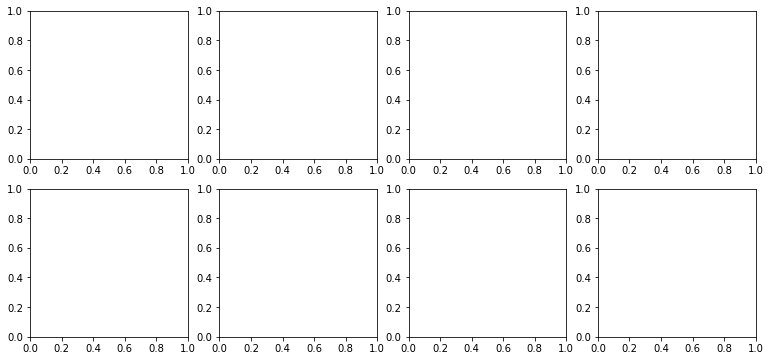

In [13]:
#currently uses moment 3 as the fixed moment, plots over the other moments

fig,axs = plt.subplots(2,4,figsize=(13,6))
for mmt0 in range(2):
    for mmt in range(4):
        idx = mmt0*4+mmt
        data = performance[3,idx]
        data = np.ma.masked_where(data==0,data)
        
        axs[mmt0,mmt].set_xticks(ticks=np.arange(0,8), labels=np.arange(-6,16,3))
        axs[mmt0,mmt].set_yticks(ticks=np.arange(0,8), labels=np.arange(-6,16,3))
        im = axs[mmt0,mmt].imshow(data, interpolation='None')
        

        # for i in range(8):
        #     for j in range(8):
        #         text = ax.text(j, i, data[i, j],
        #                        ha="center", va="center", color="w")

        axs[mmt0,mmt].set_title("4 mom MSE of dMdt (" +str( (idx)*3-6 ) + ")")
        axs[mmt0,mmt].title.set_fontsize(10)
        divider = make_axes_locatable(axs[mmt0,mmt])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im, cax=cax, orientation='vertical')
fig.tight_layout()
#cbar_ax = fig.add_axes([1, 0.15, 0.05, 0.7])
#fig.colorbar(im, cax=cbar_ax)
plt.suptitle("MSE loss of moment tendencies in 4 moment scheme given M3")

plt.savefig("4_moments_MSE_mom3_masked_log10.png")
plt.show()